<a href="https://colab.research.google.com/github/paggyhaggns/software-training/blob/main/hw4_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# installations
!pip install --upgrade pip

!python --version
!pip3 install jedi==0.16

!pip3 uninstall cvxpy -y > /dev/null
!pip3 install setuptools==65.5.0 pip==22.2 > /dev/null
# hack for gym==0.21.0 https://github.com/openai/gym/issues/3176
!pip3 install torch==1.13.1 torchvision==0.14.1 diffusers==0.30.3 \
scikit-image==0.19.3 scikit-video==1.1.11 zarr==2.12.0 numcodecs==0.10.2 \
pygame==2.1.2 pymunk==6.2.1 gym==0.21.0 shapely==1.8.4 dnn \
&> /dev/null # mute output
!pip install --upgrade "jax[cuda12_pip]"==0.4.23 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html &> /dev/null
# This will take a while, and do not worry if you get some warnings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%load_ext autoreload
%autoreload 2

import os
#change to desired path to the part2-DiffusionModels folder
os.chdir("./drive/MyDrive/Fall 2024/CS 7643/hw4_code_student_version/part2-DiffusionModels")
%pwd

In [ ]:
from part2_tests import TestCases
unit_tester = TestCases()

# Homework 4: Part 2 - Diffusion Models [30 points + 3 Extra Credit]

Denoising Diffusion Probabilistic Models (DDPM) - https://arxiv.org/abs/2006.11239/ \
Classifier Free Guidance (CFG) - https://arxiv.org/abs/2207.12598

In this part of the assignment you will be implementing a diffusion model and applying it in two different domains - a robotics task and an image generation task.  Denoising Diffusion Probabilistic Models (DDPMs), also known as Diffusion Models, are state of the art generative models that train a network to itteratively denoise random gaussian noise.  If you have not done so already, please read through the DDPM paper linked above in order to get an understanding of the math behind DDPMs.  The code for this part of the assignment is not particularly difficult, but you will have a difficult time if you do not understand the theory behind diffusion models.  You will also be implementing classifier free guidance (CFG).  While the CFG paper does not have to be read as thoroughly as the DDPM paper, it is definitely a useful read if you are not familiar with CFG.

#### Creating the DDPM

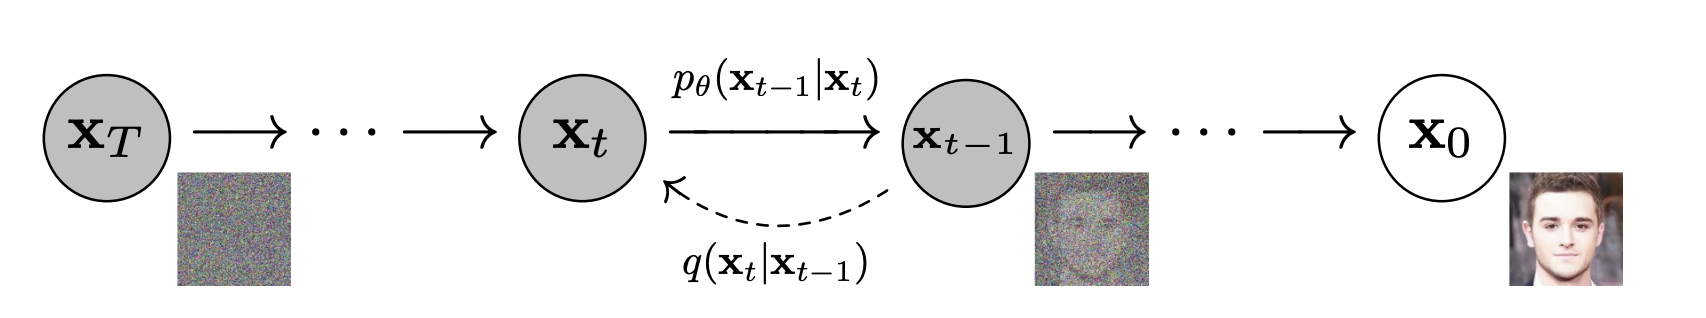

For the sake of this assignment, we are breaking the Diffusion Model into two parts.  A noise scheduler and a noise prediction net.  The noise scheduler handles the noise addition during the forward process and the noise removal during the reverse process.  The noise prediction net is a neural network that predicts the amount of noise that should be removed at each denoising step.  Transformers, like the one you implemented in the last assignment, can be used as this noise prediction network.  For this assignment we are using a U-Net as opposed to a transformer, but you will not be implementing this model, just training it.

### IMPORTANT NOTE FOR IMPLEMENTATION!

You will be generating random numbers in various sections of this project.  To keep the outputs deterministic for unit test and auto grader purposes, you <u>must</u> use our prebuilt randomizer function.  This randomizer is defined in ```part2-DiffusionModels/randomizer.py```.  Please take a look at that function before you start coding.  The function that we define is sufficient for generating any random numbers that you will need for this project.    Do not worry about passing in seeds for the robotics section (2.4)

### IMPORTANT NOTE 2
The equations in the DDPM paper describe an unconditional model, you will be implementing a conditional model.  This does not significantly change the equations, you just need to pass in the conditioning term along with $x$ and $t$.  Make sure to watch the first lecture on generative models if you are running into confusion about this or other aspects of Diffusion Models.

## Part 2.1 - Noise Scheduler [6 points]
**2.1.1** - Forward Process (Adding Noise) [3 points] [.5 writeup points]

During the forward process, we take an input and gradually add Gaussian noise to the data according to a variance schedule.  This is described in section 2, background, of the DDPM paper.  You must read that section to complete this part of the assignment.


**TODO:** Complete initialization function in ```part2-DiffusionModels/noise_scheduler.py```

**TODO:** Implement ``add_noise`` function in ``part2-DiffusionModel/noise_scheduler.py``
\
\
_Hint:_ Pay attention to equation 4
\
\
<u>Question:</u> what does $q(x_t|x_o)$ represent for a diffusion model? (read the paper)

<u>Answer:</u>  

$q(x_t|x_o)$ represnts the distrobution of noisy data at the given time $t$ given the orignal(and clean) data $x_0$. This is also known as the forward dfussion process, as we go from time step to timestep we add Noise(Gaussian in this case). The amount of noise that will be added is determined by the variance schedule. This forward process is used by the model as the main goal is to remove the noise, so the model will try and work backwards and get to $x_0$. The idea is that when $t$ is at its max level the image is almos entirely noise, and as this happens in a number of smaller steps the model can learn to reverse these changes and get back to the original(or close to it).

In [4]:
# test initialization
unit_tester.test_noise_scheduler_init()
# test add noise
unit_tester.test_add_noise()


NoiseScheduler() initialization test case passed!
add_noise() test case passed!


**2.1.2** - Reverse Process (Removing Noise) [2.5 point]

When taking a step during the backwards process, we have access to a partially noised sample $x_t$, the denoising timestep $t$, and our model's noise prediction.  We remove the predicted noise to get a slightly less noisy sample $x_{t-1}$.  The completely uncorrupted sample is recovered at $x_0$.  This process is described in detail in section 3 of the DDPM paper, please read this section before completing this part of the assignment.

*TODO:* Implement ``denoise_step`` function in ``part2-DiffusionModels/noise_scheduler.py`` (do not implement the thresholding part yet)
\
\
_Hint:_ Pay attention to algorithm 2 - Sampling

In [5]:
# test denoise step
unit_tester.test_denoise_step()


denoise_step() test case passed!


## Part 2.2 - Constructing the Diffusion Model [7 Points]

We have provided you with a noise prediction network, and you have just written a noise scheduler.  With these two parts you are able to put together a completed diffusion model.

*2.2.1* Compute Loss for Training [2 points] [.5 writeup points]
\
\
For this part of the assignment, you will be implementing the ``compute_loss_on_batch`` function of the diffusion model.  We have implemented the rest of the training logic for you. Keep in mind, the only part of the diffusion model that needs to be trained is the noise prediction network.  Your loss function should capture how well the noise_pred_net estimates the added noise.  We expect you to implement the simplified variant of the variational lower bound as described in section 3.4 of the DDPM paper.

*TODO:* Implement loss computation section of ``compute_loss_on_batch`` function in ``part2-DiffusionModels/diffusion_model.py``
\
\
_Hint:_ Use your noise scheduler, refer to equation 14 and Algorithm 1 - Training
\
_Hint:_ For each item in the batch, you should be selecting a random timestep $t$ to compute the loss
\
\
<u>Question:</u> What is $\epsilon_\theta(\sqrt{\bar{\alpha_t}}x_0 + \sqrt{1 - \bar{\alpha_t}}\epsilon, t)$ ?

<u> Answer: </u>  

$\epsilon_\theta(\sqrt{\bar{\alpha_t}}x_0 + \sqrt{1 - \bar{\alpha_t}}\epsilon, t)$ represents the models prediction of the noise that was added to the original to get the noisy sample $x_t$ at time $t$. $\sqrt{\bar{\alpha_t}}x_0 + \sqrt{1 - \bar{\alpha_t}}ϵ$ is the value for $x_t$ created during the forward process explaned in the last question. In this equation $ϵ$ is gaussian noise, and $\bar{\alpha_t}$ is the cumulative product of the noise scheduling parameters. The outer function $\epsilon_\theta()$ represnts the model trained to prdict the additional noise added to the orignal data. In other words the output of this network is the estumate of nose added to the orignal data to obtain $x_t$. Once again this is useful as it allows the model to learn how to reverse the forward diffuson, or in other words it leanrs how to denoise the image.

In [6]:
# test loss computation
unit_tester.test_compute_loss_on_batch()

compute_loss_on_batch() test case passed!


2.2.2 Classifier Free Guidance [1 Point]

We want our diffusion model to make use of classifier free guidance.  If you are not familiar with classifier free guidance, please take a look at the CFG paper now.  Classifier free guidance allows us to variably combine noise predictions from a conditional and an unconditional noise prediction network at inference time.  This has the effect of enhancing class specific features and is critical for high quality image generation.  In practice, we train the unconditional noise prediction net at the same time as the conditional noise prediction net.  Section 3.2 of the CFG paper describes this process.  

<u>We expect you to use 0s as the null tokens. </u>
\
\
*TODO:* Implement classifier free guidance section of ``compute_loss_on_batch`` function in ``part2-DiffusionModels/diffusion_model.py``
\
\
_Hint:_ This should only be a few lines, use self.p_uncond

In [7]:
# test classifier free guidance training
unit_tester.test_compute_loss_with_cfg()


compute_loss_with_cfg() test case passed!


2.2.3 Sample Generation (with classifier free guidance) [3.5 points]

Before we can actually use our diffusion model, we need to write the code for generating a sample.  To generate an output, we draw a sample $x_T$ from random gaussian noise.  We then itteratively denoise the random output for T denoising timesteps until we get our uncorrupted output $x_0$.  You will be implementing sampling with classifier-free guidance.  Do not worry about replicating algorithm 2 of the CFG paper, we only expect you to calculate the updated noise prediction from equation 6 of the CFG paper:$$ \bar{\epsilon_\theta}(x_t, t, c) = (1 + w) * \epsilon_\theta(x_t, t, c) - w * \epsilon_\theta(x_t, t, \empty) $$

where $\epsilon_\theta$ is the predicted noise from your noise prediction network and $w$ is the guidance weight

*TODO:* Implement ``generate_sample`` function in ``part2-DiffusionModels/diffusion_model.py``
\
\
_Hint:_ Use your noise scheduler and refer to Algorithm 2 - Sampling of the DDPM paper \
_Hint:_ Dont forget that this is a conditional model and to include classifier free guidance

In [8]:
# test generate sample
unit_tester.test_generate_sample()


generate_sample_step() test case passed!
generate_sample_step() with guidance test case passed!


## Part 2.3 - Diffusion Model Applications (Computer Vision) [7 points]

Diffusion models are mostly known in popular culture because of image generation tools such as Dall-e and Midjourney.  These models are able to take in text based prompts and output extremely realistic photos.  For the sake of this assignment we will not be implementing anything that is nearly as visually impressive, but we hope to shed some insight on a few critical aspects to state of the art diffusion models.  Namely classifier free guidance and thresholding.  You will be working with a subset of the CIFAR-10 dataset.  The CIFAR-10 dataset consists of 60000 32x32 color images in 10 classes, with 6000 images per class.  We will be working with the first three classes of this dataset - airplanes, automobiles, and birds.

<!-- <img src="assets/CIFAR.png" alt="CIFAR" style="width:500px" /> -->

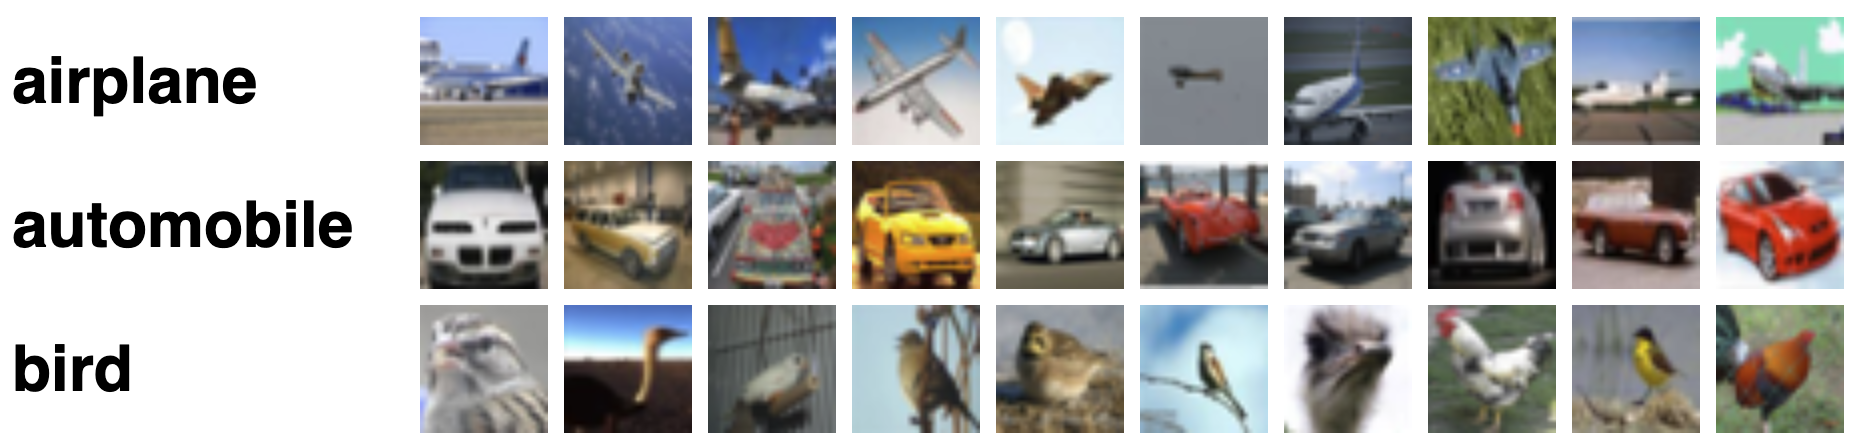

In [9]:
# Imports and global function definitions
from computer_vision.image_gen import ImageGenerator
from matplotlib import pyplot as plt

def plot_image(output):
    B, H, W, C = output.shape
    # batch size divided by number of classes
    num_cols = B // 3
    assert B % 3 == 0
    fig, axes = plt.subplots(3, num_cols, figsize=(12, 8))
    # Loop through the rows
    for i in range(3):
        # Loop through the columns
        for j in range(B // 3):
            image = output[i * (B // 3) + j]
            if num_cols == 1:
                axes[i].imshow(image)
                axes[i].axis('off')
            else:
                axes[i, j].imshow(image)
                axes[i, j].axis('off')

    # label the first row "airplane", the second row "automobile", and the third row "bird"
    axes[0, 0].set_title('airplane')
    axes[1, 0].set_title('automobile')
    axes[2, 0].set_title('bird')

    plt.show()

In [ ]:
# Run this cell to download the dataset, only needs to be done once even if you restart the notebook
%cd computer_vision
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvzf cifar-10-python.tar.gz
!rm cifar-10-python.tar.gz
%cd ..

*2.3.1* Initialization and Data Augmentation [2 writeup points]

In parts 2.1 and 2.2 you implemented diffusion model training and sample generation, so the majority of the work for generating images is done!  The computer_vision/image_gen.py file handles the rest of the logic for image generation.  Your first task is to complete the initialization function, this is only a few lines of code.
\
\
*TODO:* Complete initialization function in ``part2-DiffusionModels/computer_vision/image_gen.py``

In [11]:
generator = ImageGenerator()

After initializing the image generator, take a look through the rest of the file to understand how the data is loaded and how the images are generated.  Your next task is to perform data augmentation on the CIFAR dataset (for the sake of training time we do not require you to actually add augmenations and increase the size of your dataset, but go through this exersize with us anyway).  This is a common technique in the computer vision world as it allows us to increase the size of our dataset and train the model to be invariant to certain perturbations. You may have done this before when training a classification model, but now we are training a generator.  The types of augmentations that we want our generator to be invariant to are not necessariliy the same as for a classifier.

<u> Question: </u> _Why might we want a classifier to be invariant to different augmentations then a generator?  Name 2 augmentations that we might perform on a classification dataset that we don't want to perform on a dataset for a generative model.  Name 2 augmentations that you want to perform on a dataset for a generative model (its okay if you want also want to do the same augmentations on a classification dataset)._

<u> Your Answer Here: </u>  

The reason we want calssifiers to be invariant to different augmentations than generators is due to their goals/purposes being different. The goal of a clasfifier is to recognize an object regardless of the situation is in, a person is a person regardless of the lighting, background, or their position/orientation. On the other hand a generator is trying to create something that resmbels the original data, so if I am using a generator to show a person smiling I do not want them randomly flipped upside down, that does not make sense. In the end it all boils down to the fact that a classifier is trying to identify objects regardless of the situation, where as generators should create realisitc situations that are consistent with the training data. 2 augmentations that classification data sets would use but not generative is random flips and random rotations. A common augmentation for classifiers is flipping and rotating images as a person is still a person if they are upside down. Generative models on the other hand do not use these as it can lead to unatural outpus. For exa,ple flipping text makes it un-readable and unrealisitc, similarly randomly rotating a person would be unrealistic and out of place. As for some augmentations that do make sense for a generator we have color jittering and cropping/rescaling. Color jittering makes models create a wider array of lighting conditions while still staying in the relm of reality. Random cropping and rescaling also lets the models create different scopes of pictures, and focus areas. Again this will no change the believabiliy of the model, in fact it will make it more diverse.

*OPTIONAL:* Implement two augmentations in the ``load_dataset`` function of ``part2-DiffusionModels/computer_vision/image_gen.py``,  (these should be the augmentations you described above). Increasing the dataset size will slow down your training, so we do not require you to actually implement these augmentations.  However, we have left room for you to add the code for augmentation if you have the time or compute.  \
*OPTIONAL:* Display an image from the CIFAR dataset and show it after the augmentations (3 images total: original, augmentation 1, augmentation 2)

In [12]:
# Feel free to add more cells or generate the images separately and display them as a Markdown cell

*2.3.2* Image Generation and Classifier Free Guidance [1 writeup point]

Now it is time to train the model - if this fails to run, go and check over your previous work.
We are implementing a small model, but even still, this will take a while to train!  Please use google colab if you do not have access to a GPU.  The remainder of this assignment will be infeasable for you if you do not have a GPU.  That being said, we understand that you have time constraints and we do not expect you to let this model train for hours (although your results would look much better if you did).

We ask that you budget 30 minutes for the training of this image generation model, you can run it for longer if you prefer though.  Do not stress too much about the specific images generated, we know the outputs will be poor given your limited computation budget.  If your loss isnt decreasing (should get below 0.1 after ~7 epochs of training and below 0.05 by the end of training) or you are generating random noise, then you may have a serious issue.  But if your airplane is a smudge on a blue-ish background, that is a great output.  The goal is for you to learn, we will be paying much more attention to your analysis than your images.  

In [13]:
generator.load_dataset(dataset_paths=[
    'computer_vision/cifar-10-batches-py/data_batch_1',
    'computer_vision/cifar-10-batches-py/data_batch_2',
    'computer_vision/cifar-10-batches-py/data_batch_3',
    'computer_vision/cifar-10-batches-py/data_batch_4',
    'computer_vision/cifar-10-batches-py/data_batch_5',
    ], batch_size = 64
     )

In [ ]:
# You can just rerun this cell to keep training the model

# Keep the number of epochs at 25 for now (if you need it to be smaller that is okay as well)
# You will have a chance to increase the training time and generate your best images at the end of this section
generator.train_policy(epochs=50)
generator.policy.save_weights('model_pths/image_weights.pth')

# Load the model from the checkpoint
# generator.policy.load_weights('model_pths/image_weights.pth')
# generator.load_dataset(dataset_paths=[
#     'computer_vision/cifar-10-batches-py/data_batch_1',
#     'computer_vision/cifar-10-batches-py/data_batch_2',
#     'computer_vision/cifar-10-batches-py/data_batch_3',
#     'computer_vision/cifar-10-batches-py/data_batch_4',
#     'computer_vision/cifar-10-batches-py/data_batch_5',
#     ], batch_size = 64
#      )

First, you will evaluate the output of unguided image generation.  The generate_images will produce num_samples generations of each class.

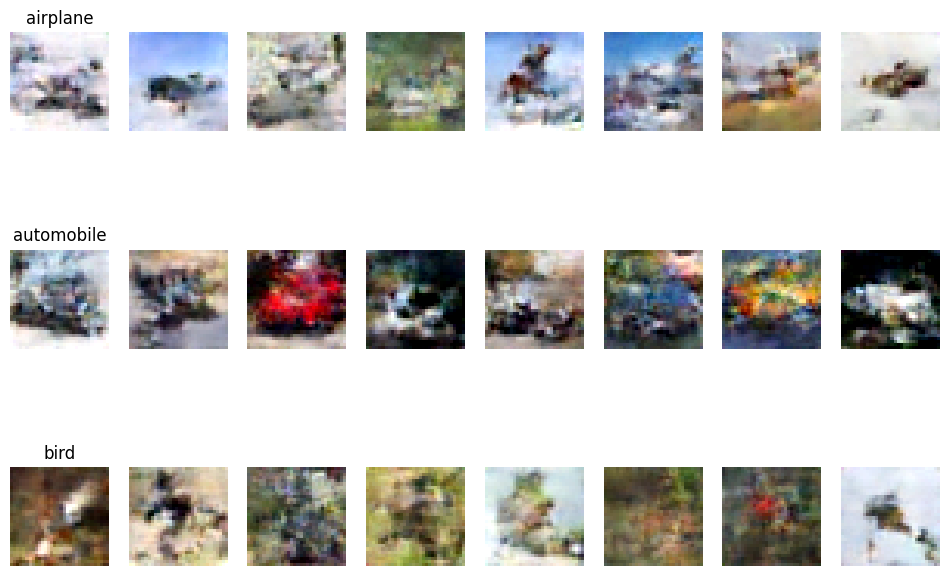

In [17]:
image = generator.generate_images(guidance=0, num_samples=8)
plot_image(image)

<u> Question: </u>  What do you notice about the quality of unguided image generation?  How effectively is the model learning each class? This is very early in the training process, but do you notice any features that the model is learning for each class?

<u> Your Answer Here: </u>  

At this point for the unguided images their quality is pretty bad. All of the images are very very blury and some still feel like the majority of the image is noise. So far it seems like the model is just starting to learn the differences/intricacies of each model(but it is quite hard to tell), with just the bare minimum features like background colors or a possibly realistic outline. Some features I think I can start to see is the backgrounds, especially for the airplane. The majority of the examples for airplane have a white/blue background that seems like a solid start for a sky or clouds. Additionally for all of them it does feel like the images do have a sense of fore-ground/subject and background meaning it is not all noise.

Now, we will evaluate image generation with different guidance weights.  To do this, we dont actually need to retrain the model at all, this guidance can be done purely at inference time. Great!  Explain why we dont have to retrain for image guidance.

<u> Your Answer Here: </u>  

The reason we do not have to retrain for image guidance is because it classfier free guidance occurs at the sampeling/inference phase. In other words we only use guidance when using the model AFTER it is trained. As I have written before during the training phase the model learns how to predict adding noise, but that does not need guidance. As for how guidance helps, durning sample/inference time we can guide the generation by using an additional term to adjust the predicted noise(the guidence weight). In our case we use the guidance weights to push the outputs towards the class we want, like airplane. To put it simply guidence is only relevant in the backwards process, something that does not happen with training. Guidence is helpful as it allows for the model to be more flexible without being expensive and long to retrain.

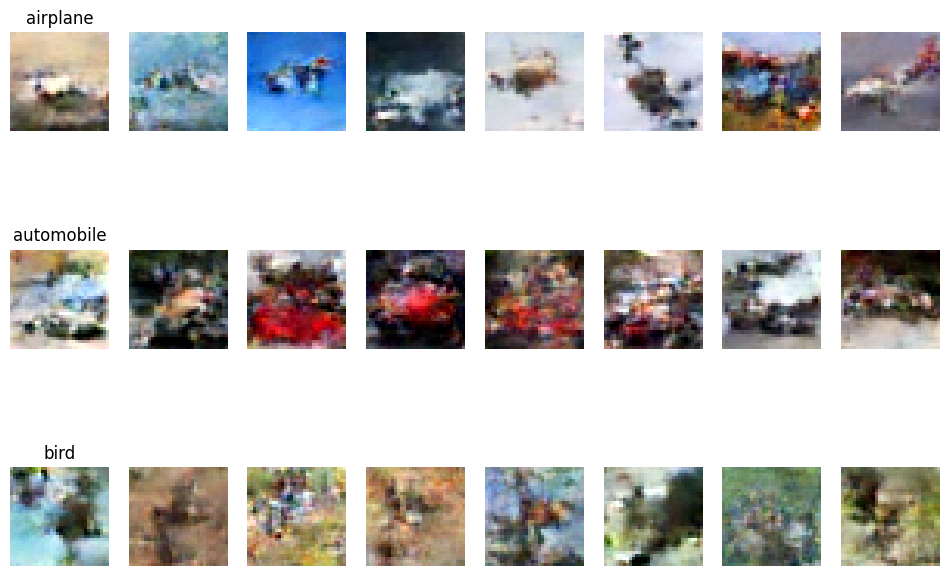

In [18]:
image = generator.generate_images(guidance=0.5, num_samples=8)
plot_image(image)

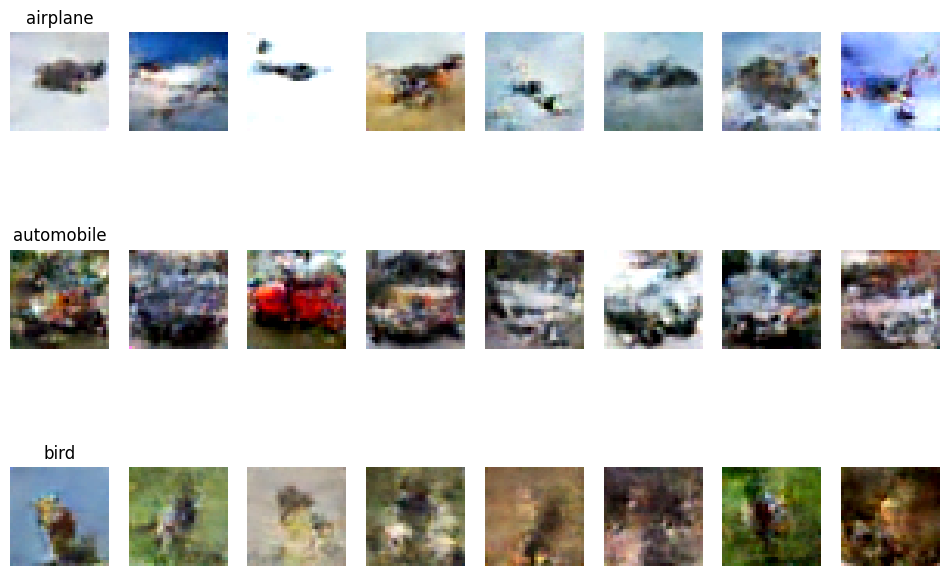

In [19]:
image = generator.generate_images(guidance=1, num_samples=8)
plot_image(image)

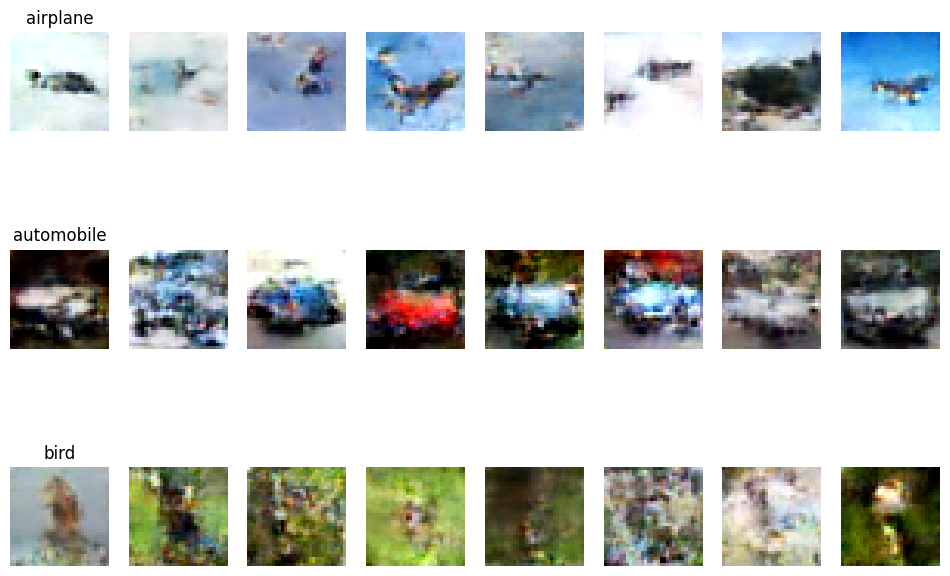

In [20]:
image = generator.generate_images(guidance=2, num_samples=8)
plot_image(image)

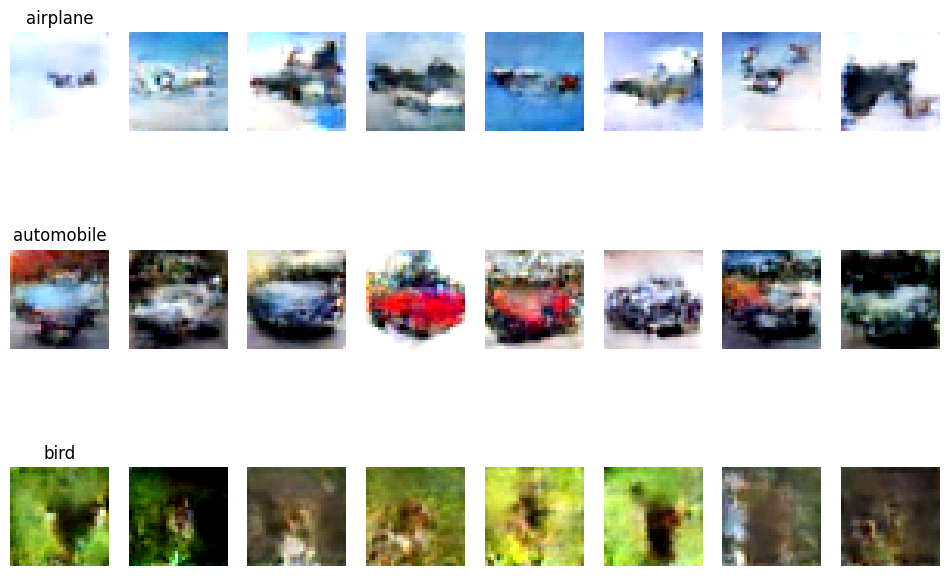

In [21]:
image = generator.generate_images(guidance=5, num_samples=8)
plot_image(image)

<u> Question :</u>  What do you notice about the generations with classifier free guidance?  What features does the model pick up as being most indicattive of each class?  Does performance degrade as guidance increases? If so, how?

<u> Your Answer Here :</u>

Overall it seems to be much better, the images all have a noticable theme and are seemingly depicting similar things unlike before. For each class it seems like the model has a few distinct features that it has latched on to. For airplanes I can see a pretty common pattern of blue/white backgrounds with some object in focus n the midde. As for the car it feels like it tends towards the color red, and in the higher guidance images I can see a tendency for side/angled images facing the car not from infront or beind(which makes sense as this is how I'd imagine most poeple take pictures of their car). Finally for the Birds it is clear there is a more earthy colored backrground with something in focus, again the higher guidance causes all the images to tend to one color, green in this case. It also does seem like the performance does go down if the guidence gets to high. First, it causes all of the images to much more similar, this is very clear in the bird example as all of the images have the same background(very green) with a similar looking focus point. Additionally, it seems like the code may be so focused on getting the class that it lets other artifacts and inconsistencies slip through.

*2.3.3* Thresholding [2 points] + [3 writeup points]

You may have noticed that with high guidance weights, the images tend to oversaturate.  This is because the model is predicting values outside of the range [-1, 1] (our input is normalized to this range before being passed to the model).  To help mitigate this, it is common to threshold sample predictions at each denoising step.  As our denoising step is currently implemented, we can't actually use this technique. This is because we directly estimate $x_{t-1}$.  Why shouldn't we just threshold $x_{t-1}$ to be within [-1, 1]?  Additionally, why is thresholding particularly useful when dealing with large guidance weights?  Will thresholding have an effect even if we don't have a large guidance weight?

<u> Your Answer Here: </u>  

The reason we do not threshold $x_{t-1}$ is beacuse if we do so we would lose some information. $x_{t-1}$ is an intermediary state that can be our of the range [-1, 1], so when we limit it we lose information and change the distrobution that the model relies on for creating the next step. As for why thresholding is helpful for large guidence weights, it is because it helps prevent oversaturation(as seen below), and it maintains realism. As guidence weights increases the emphasis the model places on the conditional information increases causing overfitting, and also exaggerated images, like color and similar images. Therefore thresholding helps keep these in check and allowing guidence without all of these issues. That being said, thresholding is still useful without large guidence, as the process of reverse diffusion is multiple steps that each are probablistic, over time we can add noise that eventually ends up outside of the possible ranges, so by usng thresholding we can stop this accuulation of error. Additionally the training data is bounded between [-1, 1] so it would only make sense we do the same when generating outputs to make the outputs even more beleivable.

So we need to compute $x_{t-1}$ such that we estimate $x_{0}$ as an intermediate step.  This way we can threshold our estimate of $x_{0}$.  
<u> This is shown in equations (6) and (7) of the DDPM paper.  The equation for computing an estimate of $x_0$ is shown in equation (15).  Make sure to threshold the prediction of $x_0$! </u>

*TODO:* Implement denoising with thresholding in the ``denoise_step`` function in ``part2-DiffusionModels/noise_scheduler.py``

In [22]:
# test denoise step with thresholding
unit_tester.test_threshold_denoise_step()

threshold_denoise_step() test case passed!


Now that you have completed the thresholding, evaluate how this changes image generation with different guidance weights.

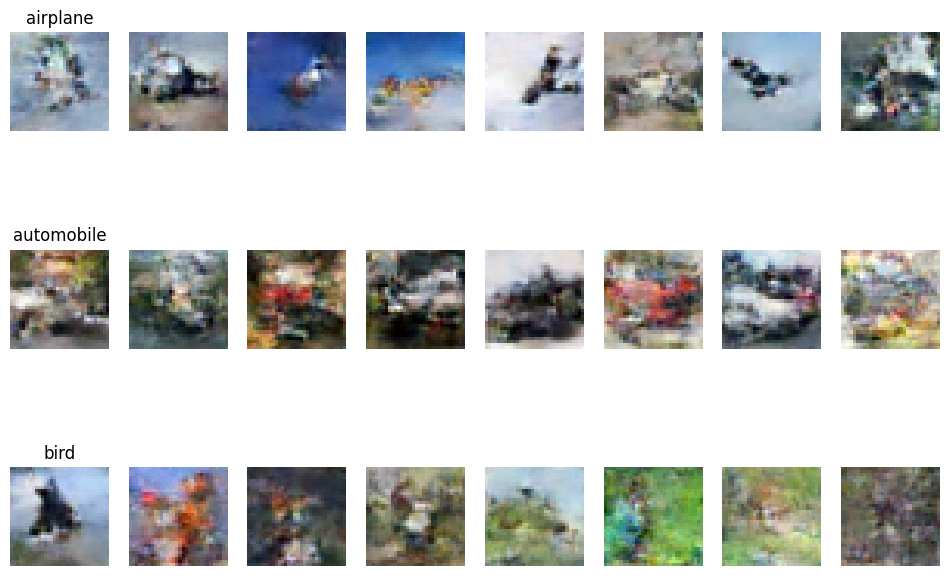

In [23]:
image = generator.generate_images(guidance=0, num_samples=8, threshold=True)
plot_image(image)

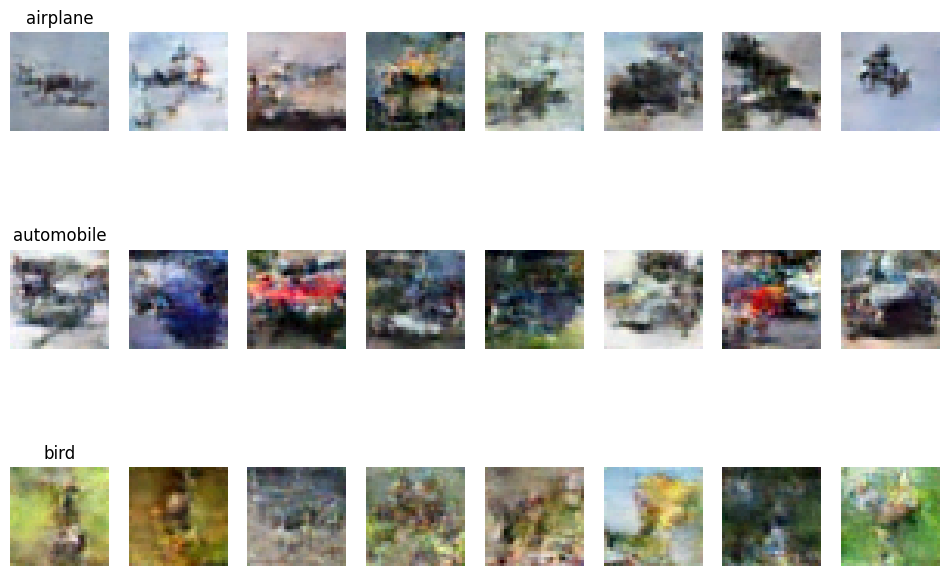

In [24]:
image = generator.generate_images(guidance=0.5, num_samples=8, threshold=True)
plot_image(image)

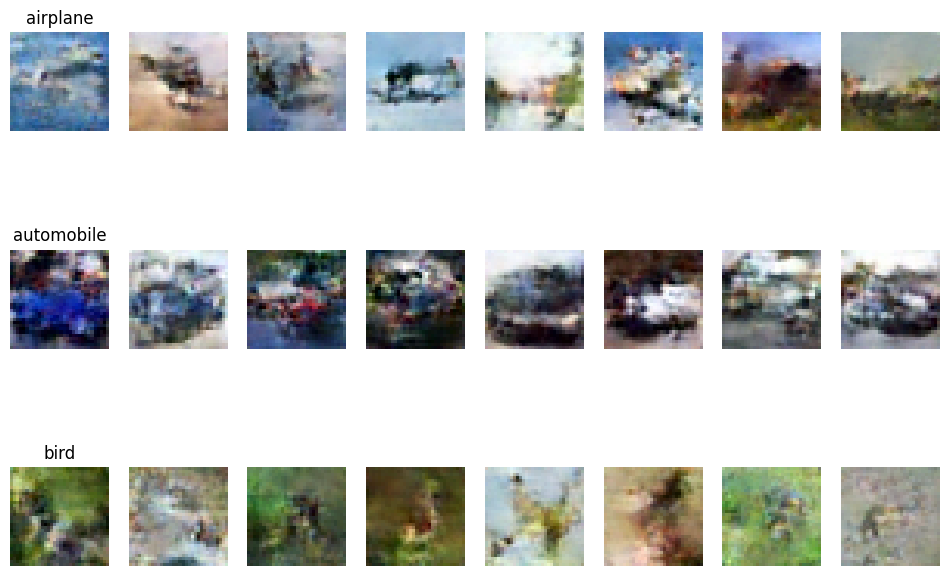

In [25]:
image = generator.generate_images(guidance=1, num_samples=8, threshold=True)
plot_image(image)

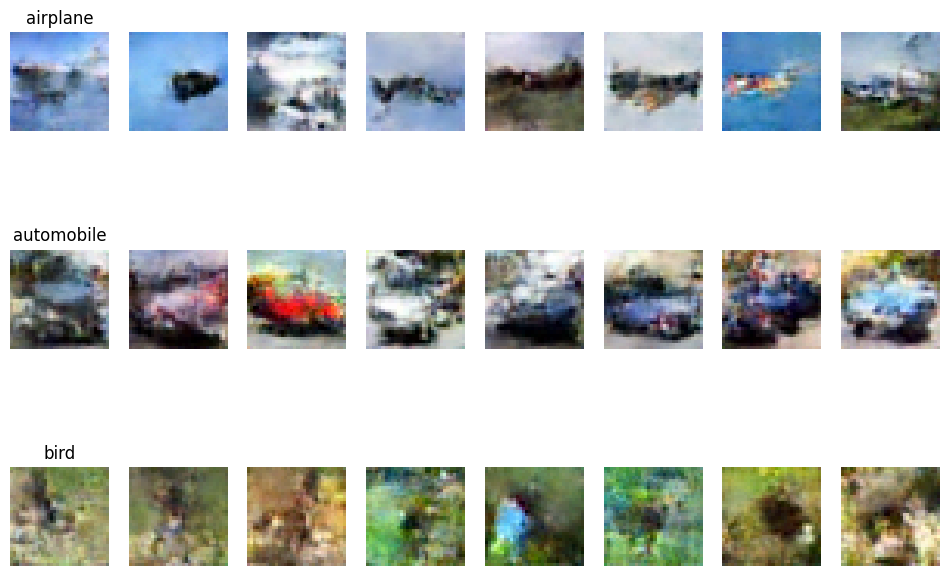

In [26]:
image = generator.generate_images(guidance=2, num_samples=8, threshold=True)
plot_image(image)

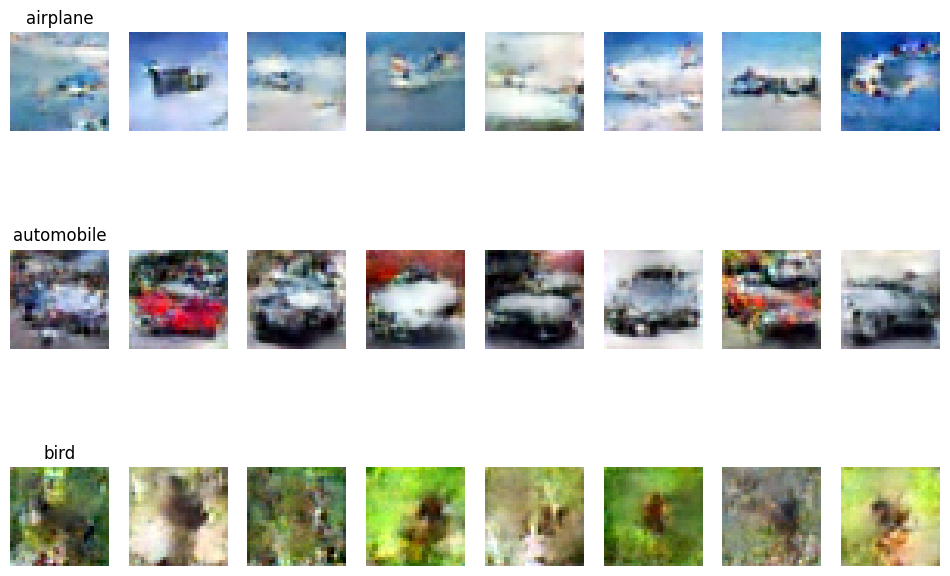

In [27]:
image = generator.generate_images(guidance=5, num_samples=8, threshold=True)
plot_image(image)

<u> Question: </u> How do the results after thresholding compare to the results before thresholding?  With thresholding and high guidance weight, which class specific features are most prominant?  Which set of parameters gave you the best output?

<u> Your Answer Here:</u>

The results with thresholding are much better, especially for he super high guidence weights. Previously the super high guidence weight images were overblown being very very bright and honestly hard to look at. However, adding the thresholdng brought everything back to a reasonable color range and make it even more clear what was background and foreground. The prominant features for the airplane seems to be settleing on a blue bacgkround for the sky and some white-ish blob in the center. For the car there is a much larger diversity in color now and there seems to be a pattern of wheels, all the images have black circles near the bottom of whatever is in focus. Finally for the birds it is less intesly green with more color variation, that being said, the "bird" that is meant to be in focus just looks like a blob, it is hard to see any detail. Overall it seemed like the guidence of 2 with thresholding gave the best images, they were diverse and not overexagerated.

*TODO:* Experiment with different training times and guidance weights!  Try and get the best image possible (or show something else interesting).  You need at least two more generations, feel free to do more are welcome though.

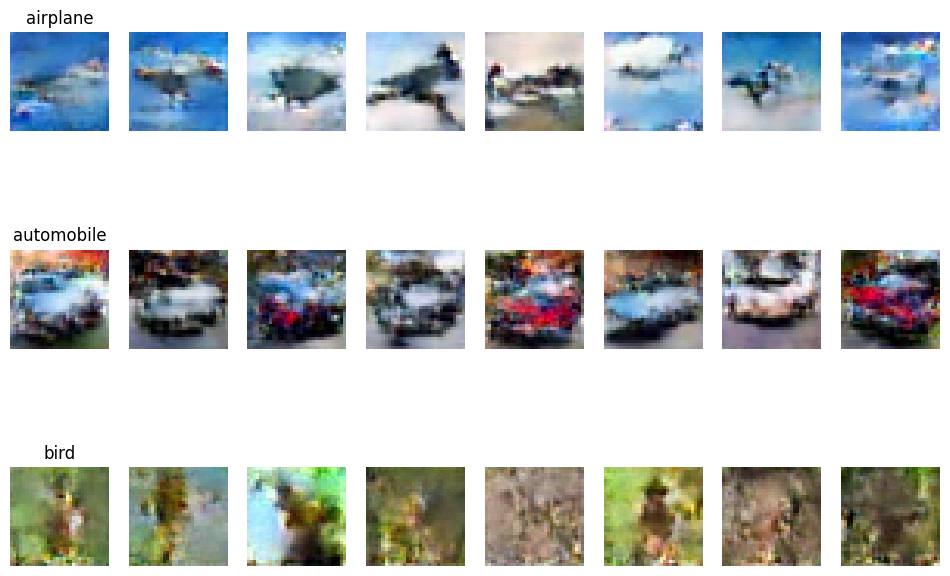

In [30]:
# anything past 8, way too much noise and they all look the same

# In the end this is the best looking I could get,  think the planes and cars are pretty good with 50% being identfiable, no matter what I did the birds are hard to ge reasonable.
image = generator.generate_images(guidance=6.75, num_samples=8, threshold=True)
plot_image(image)

## Part 2.4 - Diffusion Model Applications (Robotics) [Extra Credit - 9 points]

Diffusion models are frequently used in the image generation domain, but they are also very effective policy generators.  In the context of deep learning for robotics, we think of a policy $\pi(a | s)$ as a deep neural network that models the action, $a$, an agent can take given it's current state, $s$ (its current observation of the world).  Lets assume we have access to a set of demonstrations $D = \{\tau_i\}^N_{i=1}$ where each $\tau_i$ is a trajectory such that $\tau_i = \{s_n, a_n\}^{len(\tau_i)}_n$.  That is to say, our demonstration dataset will contain a set of states and the corresponding actions that our agent has taken from those states.  If we train a policy to model this distribution of actions given the current state, then we should be able to imitate what was demonstrated.  For this project, we will be using a diffusion model as our policy.  Here are some papers that have used diffusion models as robot policies if you are interested in reading more (you are not required to read these papers to complete this section of the project):

Diffuser - https://arxiv.org/abs/2205.09991 \
Decision Diffuser - https://arxiv.org/abs/2211.15657 \
Diffusion Policy - https://arxiv.org/abs/2303.04137

In [29]:
from IPython.display import Image, display
display(Image(filename='../assets/demo1.gif'))
display(Image(filename='../assets/demo2.gif'))
display(Image(filename='../assets/demo3.gif'))

FileNotFoundError: [Errno 2] No such file or directory: '../assets/demo1.gif'

##### Push-T Demonstration Dataset

We will be using a dataset of demonstrations where a point agent pushes a T-shaped block onto a T-shaped outline.  A visualization of a few of these demonstrations is shown above.  Here we will define a few characteristics of the dataset.

Dataset Characteristics:
- Total Demonstrations = 206
- Maximum Demonstration Length = 246 timesteps
- Action Dimension = 2 (agent_x, agent_y)
- State Dimension = 5 (agent_x, agent_y, block_x, block_y, block_rotation)
- Reward = fraction of T-shaped outline covered by T-shaped block (min = 0, max = 1)

In [ ]:
import os
import gdown

# Download the dataset
dataset_path = "robotics/push_t_dataset.zarr"
if not os.path.isfile(dataset_path):
    id = "1KY1InLurpMvJDRb14L9NlXT_fEsCvVUq&confirm=t"
    gdown.download(id=id, output="robotics/push_t_dataset.zarr.zip", quiet=False)

    # unzip the downloaded file
    !unzip -q robotics/push_t_dataset.zarr.zip -d robotics/push_t_dataset.zarr
    !rm robotics/push_t_dataset.zarr.zip

2.4.1 Constructing the Training Dataset [2 points]

In order to train the diffusion model, we need to get our demonstrations in the correct format.  Remember, our goal is for the diffusion model to learn $q(a|s)$, the distribution of actions given the current state.  So the model inputs are actions and the conditioning terms are states.  Naively, we would turn a demonstration of length L into L different data points.  Each datapoint would have one action and one state that it is conditioned on.

In practice, we do not predict one action at a time, we predict a sequence of actions.  This is known as action chunking in the robotics literature (https://arxiv.org/abs/2304.13705).  Additionally, it is common to condition on multiple previous states, not just the current state (we can't condition on future states because they haven't happened yet).  For this assignment, we want the diffusion model to be conditioned on $H_s$ states and we want the model to generate $H_a$ actions at a time ($H_s < H_a$).


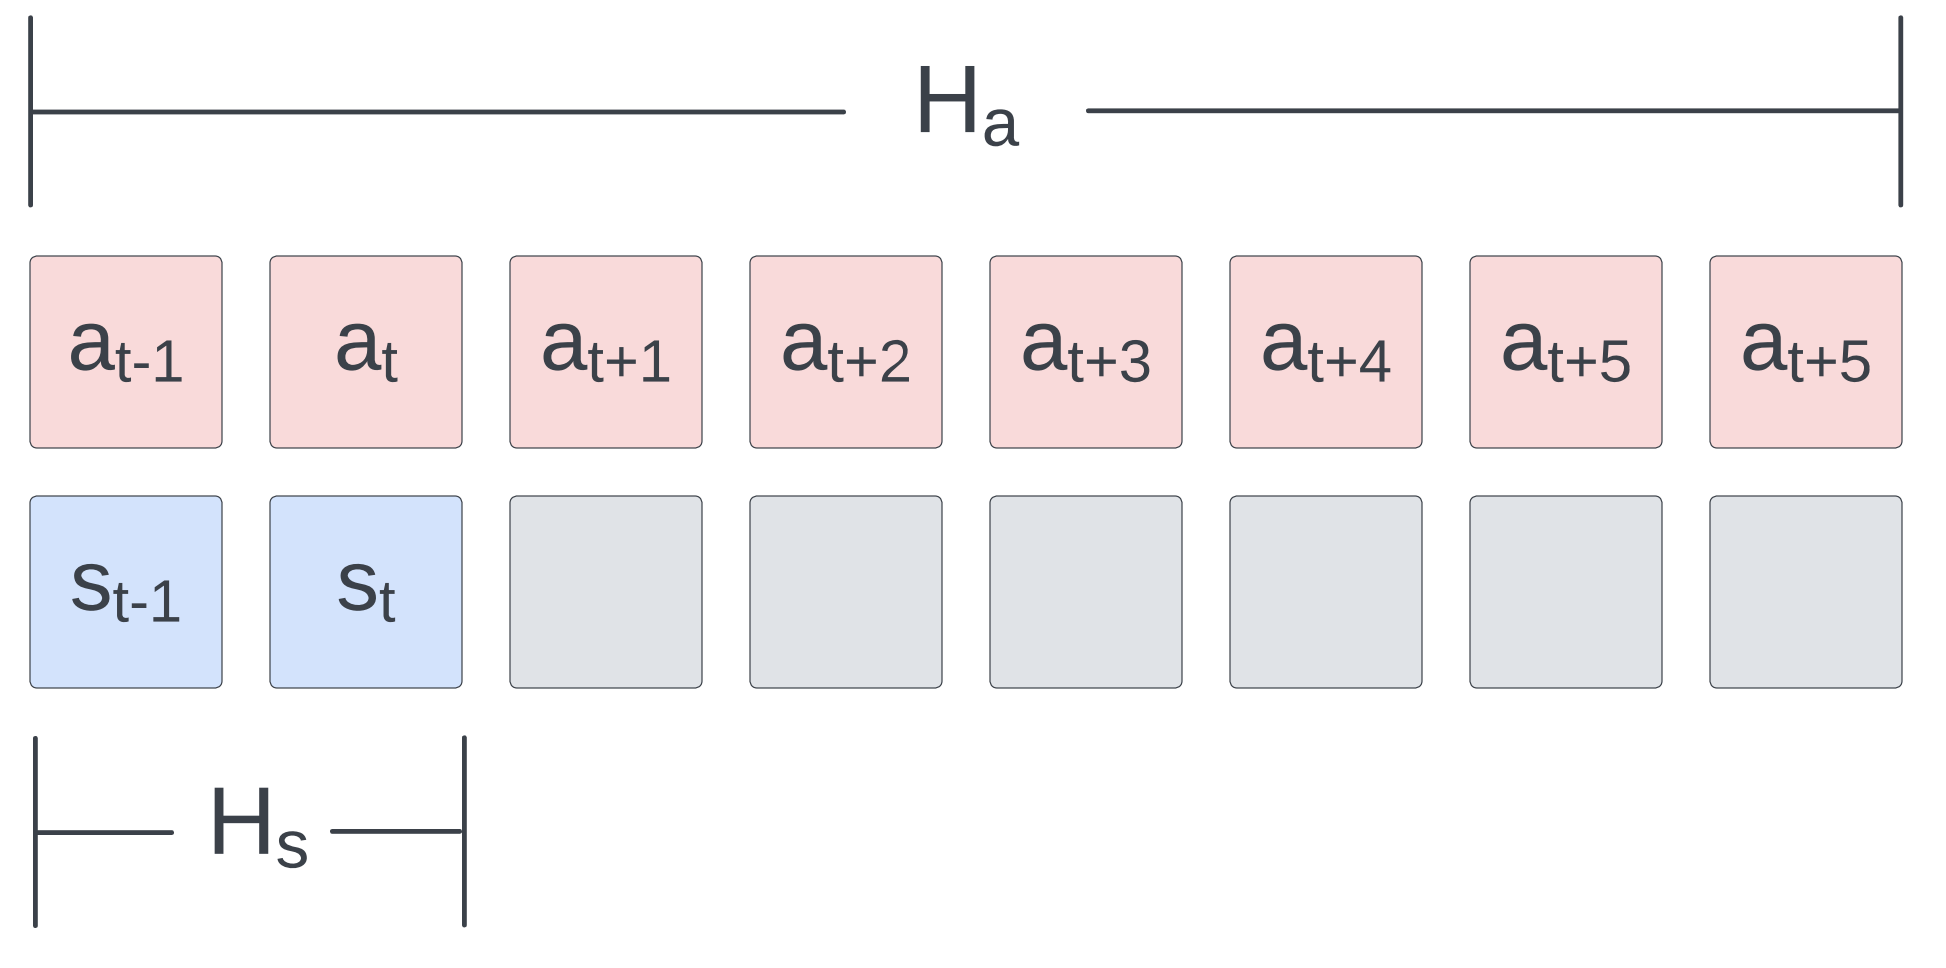

But what if we are at the beginning of a demonstration where $s_{0-x}$ and $a_{0-x}$ do not exist?  Then you should repeat $s_0$ and $a_0$ for the appropriate number of times.  What if we are at the end of a demonstation where future states and actions do not exist?  Then you should repeat the final values for the appropriate number of times.

*TODO:* Complete the ``load_dataset`` function in ``part2-DiffusionModels/robotics/dataset.py`` \
*TODO:* Complete the initialization function in ``part2-DiffusionModels/robotics/runner.py``


In [ ]:
# test load dataset
unit_tester.test_robotics_dataset()

With the initialization and the data loading complete, you should now be able to train a diffusion based policy (this may take a while to run).  If this fails, your initialization may be incorrect.  We recommend running the training for ~20 epochs first so that you can see if your output is reasonable.  If the agent is just moving around randomly, this indicates that something is wrong with your code.  If the agent is moving the block but having a hard time getting it over the outline, then continue training for the final 30 epochs

Loss should get to ~0.05 by the end of training and be below 0.1 after 10 epochs

In [ ]:
from robotics.runner import EnvRunner
# train model
runner = EnvRunner()
runner.load_data(dataset_path='robotics/push_t_dataset.zarr/', batch_size = 256)

In [ ]:
# You can keep running this cell to train the model for longer (50 epochs should be enough if your implementation is correct)
runner.train_policy(50)
runner.policy.save_weights('model_pths/robotics_weights.pth')

# Load the model from the checkpoint
# runner.policy.load_weights('model_pths/robotics_weights.pth')
# runner.load_data(dataset_path='robotics/push_t_dataset.zarr/', batch_size = 256)

2.4.2 Generating a Rollout [5 points for success rate] + [2 writeup points]

Now that you have a trained policy, we can generate a complete rollout.  If everything is done correctly, you should see the agent move the T-shaped block over the T-shaped outline.

To rollout a policy for T timesteps we do the following:
- Initialize Environment
- For t in range(T)
    - get action: <u> this is what you have to implement </u>
    - reward, state = env.step(action)
    - if reward == maximum_reward (unlikely to happen even if your implementation is correct)
        - break

T is set to 250 (based on the maximum demonstration length)

We have implemented most of the logic for you - your only task it to generate actions.  When predicting a horizon of actions, it is common to not actually carry out all of those predicted actions. Instead, you carry out a subset of those predicted actions in open loop and then re-plan. So if you generate $H_a$ actions, you only roll out $N_{actions} < H_a$ of those actions before generating a new set of actions.  Here is a visual representation:

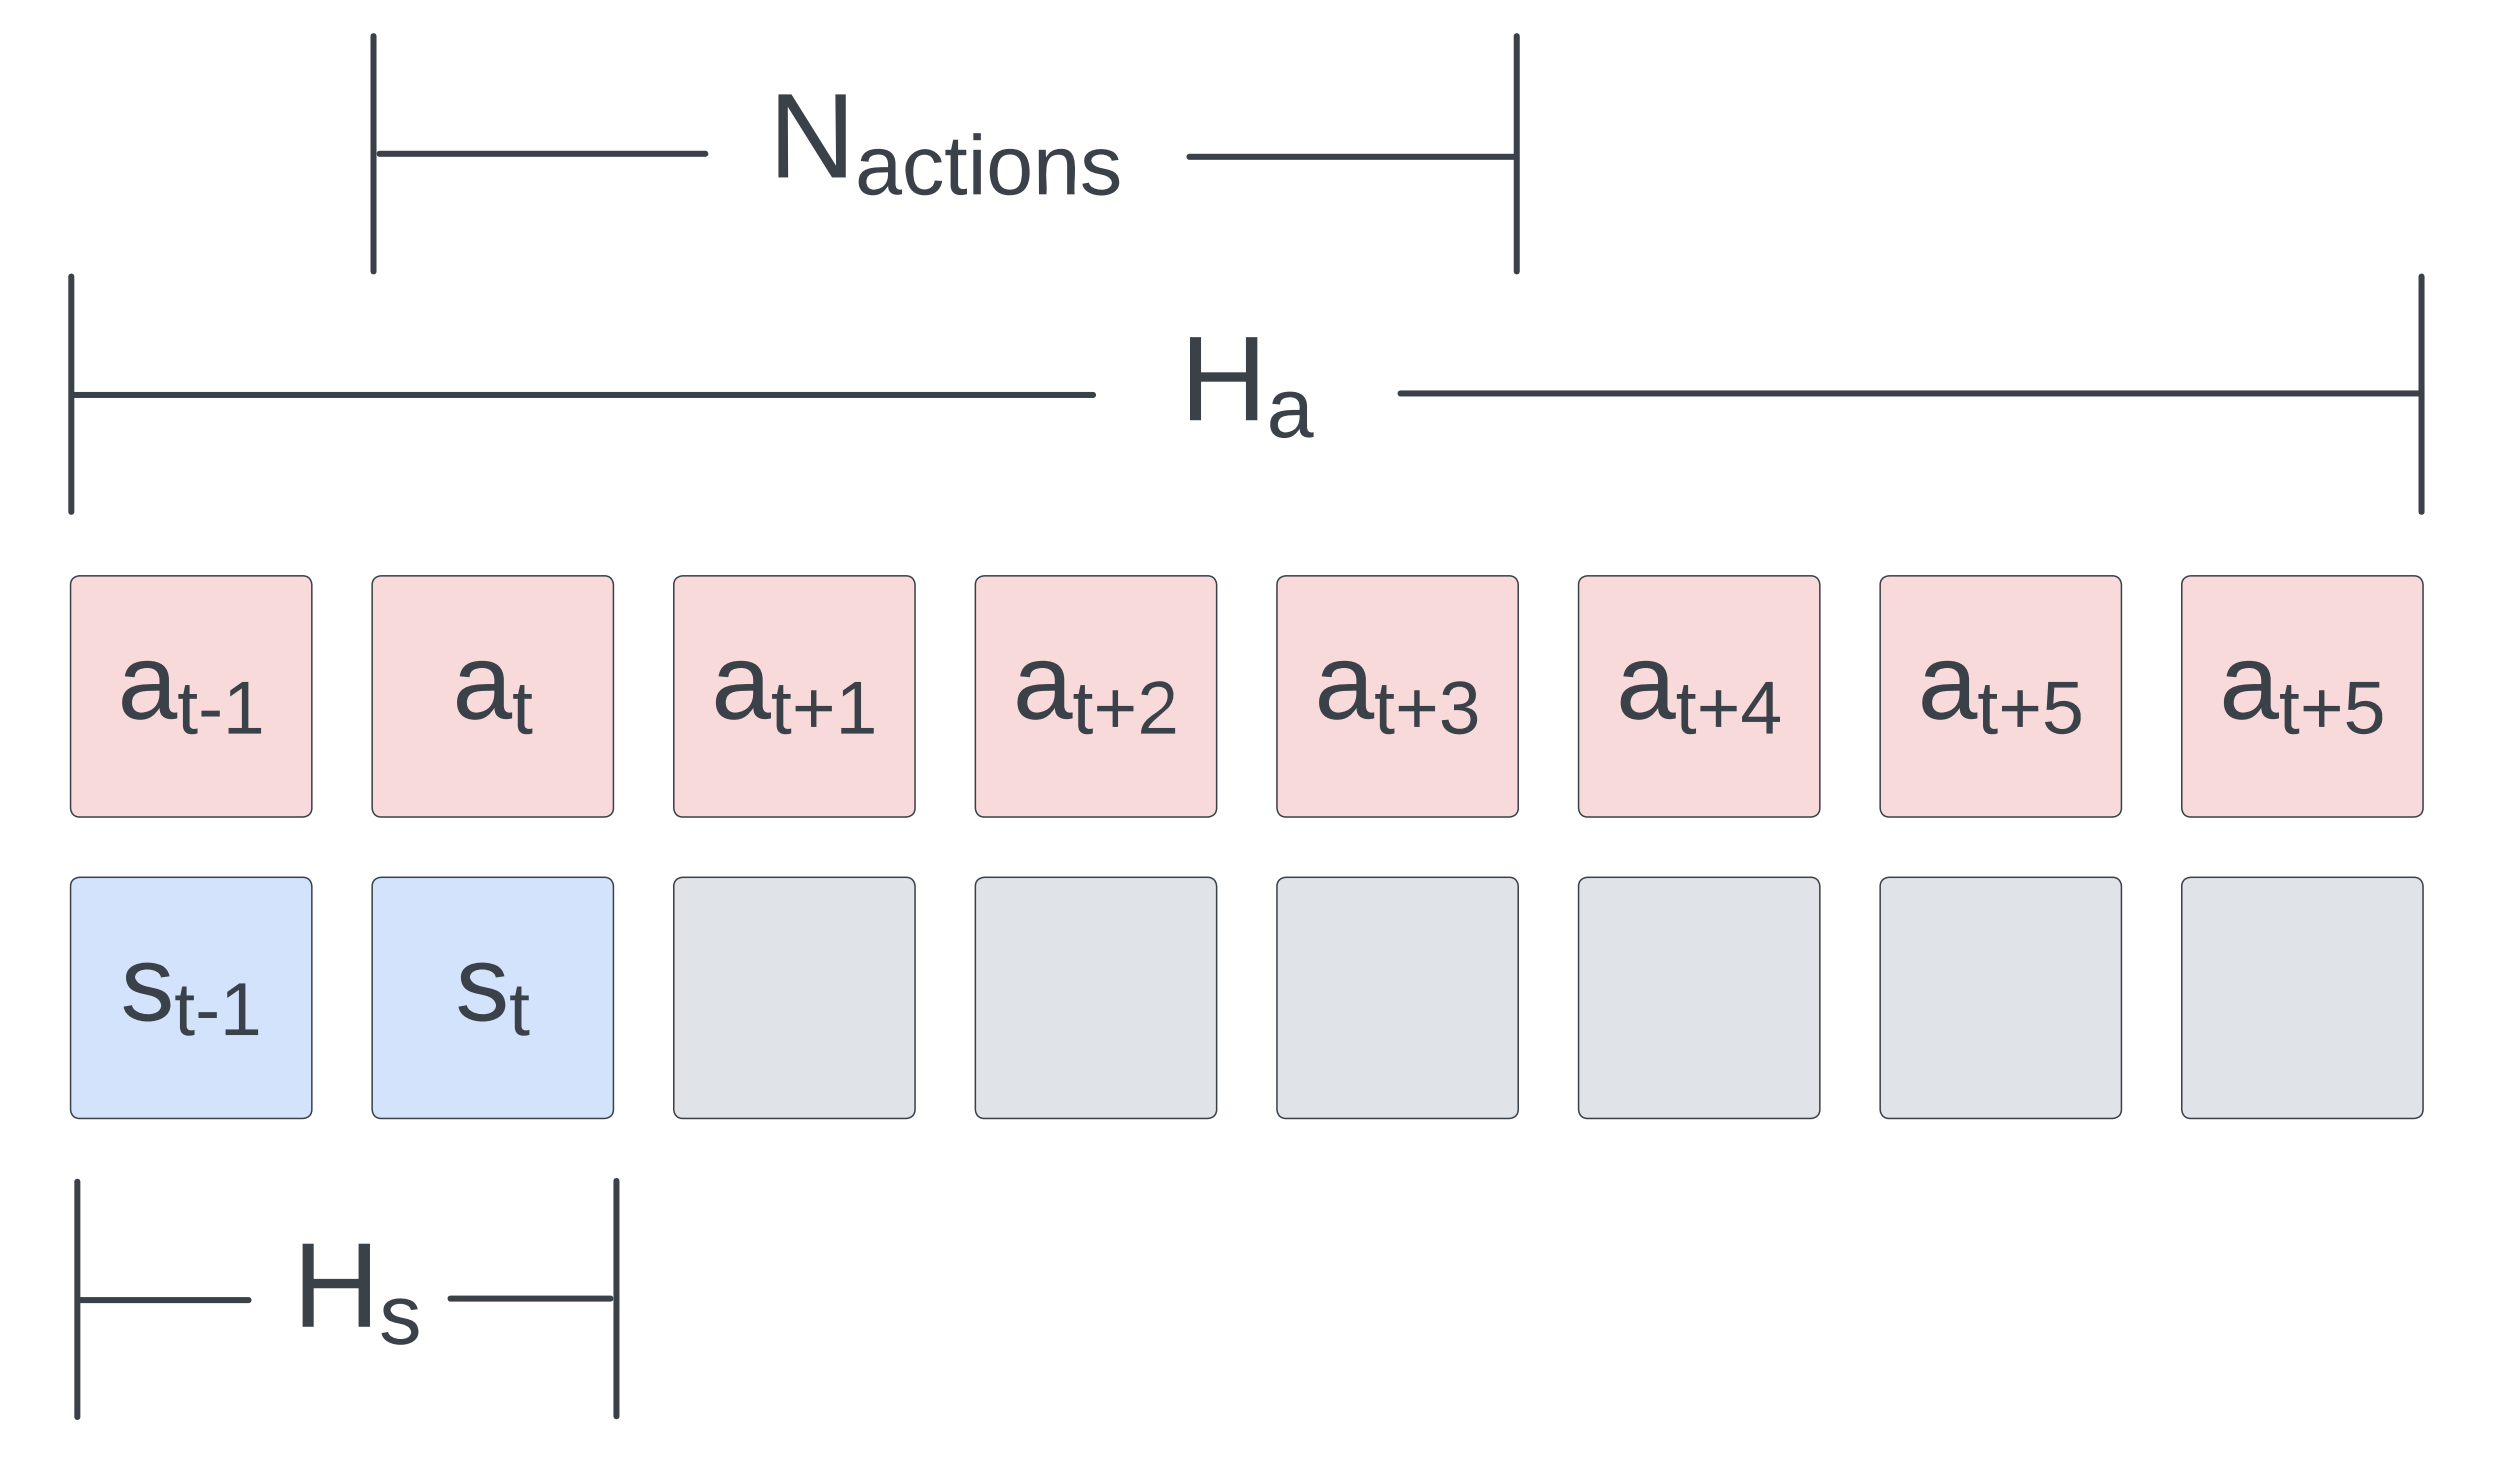

*TODO:* Complete implementation of ``run_rollout`` in ``part2-DiffusionModels/robotics/runner.py`` \
*Note:* We want the guidance weight to be zero

_Hint:_ We generate $H_a$ actions at a time, and carry out $N_{actions}$ of those actions.  So you should not actually be generating actions at every timestep

In [ ]:
# generate rollout
imgs, max_images = runner.run_rollout()

To get full credit for this section your maximum reward should be greater than 0.7

There is definitly an element of randomization with diffusion models, so if the movement is reasonable feel free to run the rollout again or train for a little longer.

In [ ]:
# Video of the rollout to help you debug
from skvideo.io import vwrite
from IPython.display import Video
vwrite('vis.mp4', imgs)
Video('vis.mp4', embed=True, width=256, height=256)

In [ ]:
# Images of the timesteps leading up to max reward (so we can see that it did not just randomly reach the goal)

# Plot images in a row
from matplotlib import pyplot as plt
fig, axes = plt.subplots(1, len(max_images), figsize=(12, 8))
for i in range(len(max_images)):
    axes[i].imshow(max_images[i])
    axes[i].axis('off')

<u> Question:</u>. What did you learn from training this model?  Did you notice any interesting behavior?  Even if you never got a high reward, where did you notice the agent failing?

<u> Your Answer:</u>

### Part 3 - Experiments [Extra Credit - 3 points max]

This section is very open ended, it is your chance to experiment with the models you have created and earn some extra credit points.  Be creative!  We are looking for interesting analysis and visualization.  The more effort you put into this section, the more points you can get.
\
\
Suggestions for conducting a good experiment:
- Be systematic and scientific
    - Clearly state the variable you will changing
    - Define an evaluation metric
    - Come up with a hypotheses (why might changing these values even matter)?
    - Do a reasonable sweep over parameter values (does not need to be too extensive)
- Visualizations
    - Graphs, pictures, and rollout videos are easier to digest than tables of numbers
- Analysis
    - Don't just report the results, think about what they mean
    - Is the behavior what you expected?
    - What additional questions does this leave you with?
    - What did you learn (even if your experiment failed or is only partially completed)?

We will be sure to shout out the best experiments in a Piazza post!

#### Collect Submission

Run the following cell to collect ```hw4_submission_p2.zip```.  You will submit this to HW4 Code - Part 2 on gradescope.  Make sure to also export a PDF of this jupyter notebook and attach that to the end of your theory section.  This PDF must show your answers to all the questions in the document, please leave in all the photos that you generate as well.  You will not be given credit for anything that is not visible to us in this PDF.

In [ ]:
%%bash collect_submission_part2.sh

*Contributers*
- Matthew Bronars (Lead)
- Manav Agrawal
- Mihir Bafna